In [685]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Setup

In [686]:
import numpy as np
import cv2
import tensorflow as tf
import os
import random
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm import tqdm
from tensorflow.keras.applications import MobileNetV2
print(os.getcwd())

/content


In [687]:
#paths
csv_path = 'drive/MyDrive/Colab Notebooks/IIIP/Testing Chamber/seen.csv'
seen_folder_path = 'drive/MyDrive/Colab Notebooks/IIIP/Testing Chamber/embeddings_1024/seen'
unseen_folder_path = 'drive/MyDrive/Colab Notebooks/IIIP/Testing Chamber/embeddings_1024/unseen/Potato___healthy'
embedding_generator = 'drive/MyDrive/Colab Notebooks/IIIP/Testing Chamber/Models/emb_gen.hdf5'
embedding_generator_onehot = 'drive/MyDrive/Colab Notebooks/IIIP/Testing Chamber/Models/onehot_emb_gen.hdf5'

In [688]:
folders = os.listdir(seen_folder_path)
print(folders)

df = pd.read_csv(csv_path, header = None)
print(df)

['Tomato___healthy', 'Peach___healthy', 'Peach___Bacterial_spot', 'Tomato___Early_blight', 'Potato___Early_blight', 'Tomato___Bacterial_spot']
                         0  1  2  3
0  Tomato___Bacterial_spot  0  0  0
1   Peach___Bacterial_spot  1  0  1
2          Peach___healthy  1  1  2
3         Tomato___healthy  0  1  3
4    Potato___Early_blight  2  2  4
5    Tomato___Early_blight  0  2  5


In [689]:
# make dataset
unseen_dataset = []
plant_dataset_real = []
disease_dataset_real = []
plant_labels = {}
disease_labels = {}
combined_label_dict = {}

##Data loader

###Seen dataset

In [727]:
for index,row in df.iterrows():
  curr_folder_path = seen_folder_path + "/" + str(row[0])
  embeddings = os.listdir(curr_folder_path)
  plant_labels[row[1]] = (str(row[0]).split("___"))[0]
  disease_labels[row[2]] = (str(row[0]).split("___"))[1]
  combined_label_dict[row[3]] = str(row[0])
  for i in tqdm(range(0,200)):
      select = random.choice(embeddings)
      embed = np.load(os.path.join(curr_folder_path, select))
      plant_dataset_real.append((embed, row[1]))
      disease_dataset_real.append((embed, row[2]))
      embeddings.remove(select)

100%|██████████| 200/200 [00:01<00:00, 113.12it/s]


In [728]:
print("Real plant image dataset\n===============================")
print(plant_labels)
print(len(plant_dataset_real))

print("\nReal disease image dataset\n===============================")
print(disease_labels)
print(len(disease_dataset_real))

print("\nCombined labels:")
print(combined_label_dict)

Real plant image dataset
{0: 'Tomato', 1: 'Peach', 2: 'Potato'}
2400

Real disease image dataset
{0: 'Bacterial_spot', 1: 'healthy', 2: 'Early_blight'}
2400

Combined labels:
{0: 'Tomato___Bacterial_spot', 1: 'Peach___Bacterial_spot', 2: 'Peach___healthy', 3: 'Tomato___healthy', 4: 'Potato___Early_blight', 5: 'Tomato___Early_blight'}


###Unseen dataset

In [729]:
curr_folder_path = unseen_folder_path
print(curr_folder_path)
embeddings = os.listdir(curr_folder_path)
for i in tqdm(embeddings):
    embed = np.load(os.path.join(curr_folder_path, i))
    unseen_dataset.append(embed)


drive/MyDrive/Colab Notebooks/IIIP/Testing Chamber/embeddings_1024/unseen/Potato___healthy


100%|██████████| 152/152 [00:00<00:00, 211.25it/s]


###Real + Fake dataset

####Image Generator architecture

In [730]:
from tensorflow.keras import layers
latent_dim = 100
classes = 6
def define_generator(latent_dim=latent_dim, n_classes=classes):
    noise = layers.Input(shape=(latent_dim,))
    label = layers.Input(shape=(1,))

    label_embedding = layers.Flatten()(layers.Embedding(classes, latent_dim)(label))
    model_input = layers.Concatenate()([noise, label_embedding])

    x = layers.Dense(64)(model_input)
    x = layers.Dense(256, activation = 'relu')(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(512, activation = 'relu')(x)
    out_layer = layers.Dense(1024, activation = 'linear')(x)

   # define model
    model = tf.keras.Model([noise, label], out_layer)
    return model

embed_gen = define_generator()
embed_gen.load_weights(embedding_generator)
print(embed_gen.summary())

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_118 (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 embedding_17 (Embedding)       (None, 1, 100)       600         ['input_118[0][0]']              
                                                                                                  
 input_117 (InputLayer)         [(None, 100)]        0           []                               
                                                                                                  
 flatten_109 (Flatten)          (None, 100)          0           ['embedding_17[0][0]']           
                                                                                           

In [731]:
# def define_generator_onehot(latent_dim=latent_dim, n_classes=classes):
#     noise = layers.Input(shape=(latent_dim,))
#     label = layers.Input(shape=(6,))

#     label_embedding = layers.Flatten()(layers.Embedding(classes, latent_dim)(label))
#     model_input = layers.Concatenate()([noise, label_embedding])
#     x = layers.Flatten()(model_input)
#     x = layers.Dense(64)(x)
#     x = layers.Dense(256, activation = 'relu')(x)
#     x = layers.Dropout(0.4)(x)
#     x = layers.Dense(512, activation = 'relu')(x)
#     out_layer = layers.Dense(1024, activation = 'linear')(x)

#    # define model
#     model = tf.keras.Model([noise, label], out_layer)
#     return model
# embed_gen = define_generator_onehot()
# embed_gen.load_weights(embedding_generator_onehot)
# print(embed_gen.summary())

In [732]:
# class_to_onehot = {
#     0: (0, 0),
#     1: (1, 0),
#     2: (1, 1),
#     3: (0, 1),
#     4: (2, 2),
#     5: (0, 2)
# }
# def into_onehot(class_no):
#   pair = class_to_onehot[class_no]
#   return np.concatenate((tf.one_hot(pair[0], depth=3), tf.one_hot(pair[1], depth=3)), axis=0)

####Generate fake images

In [733]:
fake_dataset = []
seed = tf.random.normal([100, latent_dim])
seed.dtype

for i in range(6):
  curr_label = []
  for j in range(100):
    curr_label.append(i)
  curr_label = tf.convert_to_tensor(curr_label)
  gen = embed_gen([seed, curr_label], training=False)
  for emb in gen:
    fake_dataset.append((np.array(emb).reshape((1, 1024)), i))
print(len(fake_dataset))

600


In [734]:
# def label_gen(n):
#     lab = []
#     for i in range(100):
#       lab.append(n)
#     return lab

In [735]:
# fake_dataset = []
# seed = tf.random.normal([100, latent_dim])
# seed.dtype
# for i in range(6):
#   labels = label_gen(i)
#   onehot_labels = []
#   for i in labels:
#       onehot_labels.append(into_onehot(i))
#   gen = embed_gen([seed, np.array(onehot_labels)], training=False)
#   for emb in gen:
#      fake_dataset.append((np.array(emb).reshape((1, 1024)), i))


In [736]:
plant_dataset_fake = []
disease_dataset_fake = []
import matplotlib.pyplot as plt

for emb, lab in fake_dataset:
  label = combined_label_dict[lab]
  plant = (label.split("___"))[0]
  disease = (label.split("___"))[1]
  plant_dataset_fake.append((emb, list(plant_labels.values()).index(plant)))
  disease_dataset_fake.append((emb, list(disease_labels.values()).index(disease)))

print(len(plant_dataset_fake))
print(len(disease_dataset_fake))

real_fake_plant_dataset = np.concatenate((plant_dataset_real, plant_dataset_fake), axis=0)
real_fake_disease_dataset = np.concatenate((disease_dataset_real, disease_dataset_fake), axis=0)

print(len(real_fake_plant_dataset))
print(len(real_fake_disease_dataset))
print(np.array(real_fake_plant_dataset).shape)
print(np.array(real_fake_disease_dataset).shape)

600
600
3000
3000
(3000, 2)
(3000, 2)


<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


#Real image classifier

##Architecture

In [770]:
plant_embedding_real = tf.keras.Sequential([
    # label input
    layers.Input(shape=(1024)),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Flatten(),
    layers.Dropout(0.4),
    # output
    layers.Dense(3, activation='softmax')
])

disease_embedding_real = tf.keras.Sequential([
    # label input
    layers.Input(shape=(1024)),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Flatten(),
    layers.Dropout(0.4),
    # output
    layers.Dense(3, activation='softmax')
])

##Plant classifier

In [771]:
np.random.shuffle(plant_dataset_real)
train, test = train_test_split(plant_dataset_real, test_size = 0.4)

train_embeddings = np.array([item[0] for item in train])
train_labels = np.array([item[1] for item in train])

test_embeddings = np.array([item[0] for item in test])
test_labels = np.array([item[1] for item in test])

print("Train length: ", str(len(train_embeddings)))
print("Test length: ", str(len(test_embeddings)))

train_embeddings = train_embeddings.reshape(len(train_embeddings), 1024)
train_labels = tf.one_hot(train_labels, depth=3)

test_embeddings = test_embeddings.reshape(len(test_embeddings), 1024)
test_labels = tf.one_hot(test_labels, depth=3)

print(train_embeddings.shape)
print(test_embeddings.shape)

Train length:  1440
Test length:  960
(1440, 1024)
(960, 1024)


In [772]:
plant_embedding_real.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])
plant_embedding_real.summary()

Model: "sequential_86"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_416 (Dense)           (None, 512)               524800    
                                                                 
 dropout_190 (Dropout)       (None, 512)               0         
                                                                 
 dense_417 (Dense)           (None, 128)               65664     
                                                                 
 dense_418 (Dense)           (None, 32)                4128      
                                                                 
 flatten_114 (Flatten)       (None, 32)                0         
                                                                 
 dropout_191 (Dropout)       (None, 32)                0         
                                                                 
 dense_419 (Dense)           (None, 3)               

In [773]:
# train the model
history = model_fit = plant_embedding_real.fit(train_embeddings, train_labels, epochs=10, validation_data=(test_embeddings, test_labels))

# evaluate model
_, real_plant_train_acc = plant_embedding_real.evaluate(train_embeddings, train_labels)
_, real_plant_test_acc = plant_embedding_real.evaluate(test_embeddings, test_labels )

print(f'\nTrain accuracy: {real_plant_train_acc:.0%}')
print(f'Test accuracy: {real_plant_test_acc:.0%}')

plant_embedding_real.save('drive/MyDrive/Colab Notebooks/IIIP/Testing chamber/Models/plant_embedding_real_classifier.hdf5')


Epoch 1/10
45/45 [==============================] - 2s 8ms/step - loss: 1.1384 - accuracy: 0.5826 - val_loss: 0.2890 - val_accuracy: 0.9229
Epoch 2/10
45/45 [==============================] - 0s 5ms/step - loss: 0.4379 - accuracy: 0.8167 - val_loss: 0.1336 - val_accuracy: 0.9573
Epoch 3/10
45/45 [==============================] - 0s 5ms/step - loss: 0.2726 - accuracy: 0.8944 - val_loss: 0.0826 - val_accuracy: 0.9708
Epoch 4/10
45/45 [==============================] - 0s 6ms/step - loss: 0.2119 - accuracy: 0.9271 - val_loss: 0.0743 - val_accuracy: 0.9750
Epoch 5/10
45/45 [==============================] - 0s 5ms/step - loss: 0.1676 - accuracy: 0.9410 - val_loss: 0.0656 - val_accuracy: 0.9750
Epoch 6/10
45/45 [==============================] - 0s 5ms/step - loss: 0.1430 - accuracy: 0.9556 - val_loss: 0.0580 - val_accuracy: 0.9771
Epoch 7/10
45/45 [==============================] - 0s 5ms/step - loss: 0.1121 - accuracy: 0.9653 - val_loss: 0.0552 - val_accuracy: 0.9792
Epoch 8/10
45/45 [==

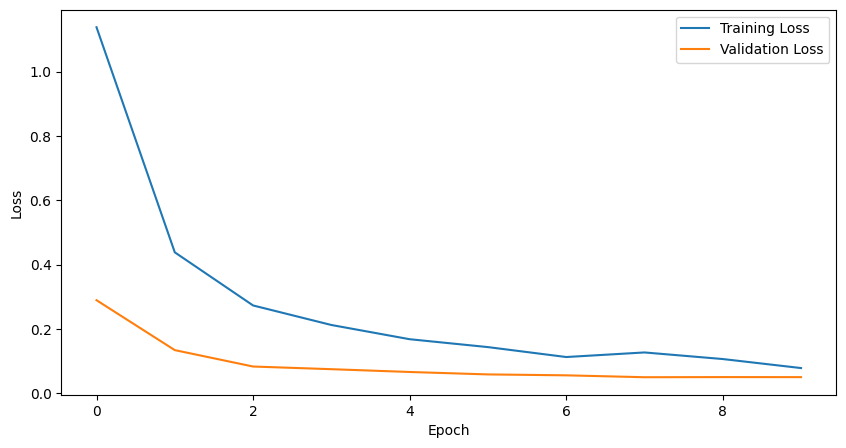

In [774]:
# Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

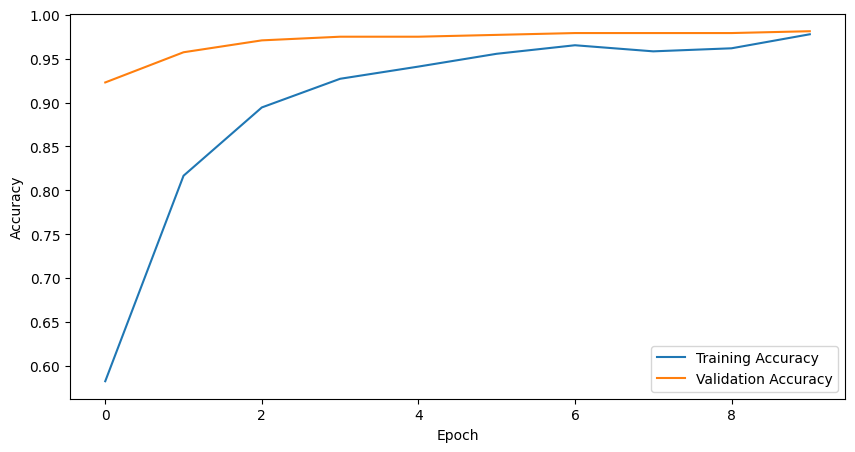

In [775]:
# Extract accuracy values
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot the accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

##Disease classifier

In [776]:
np.random.shuffle(disease_dataset_real)

train, test = train_test_split(disease_dataset_real, test_size = 0.4)

train_embeddings = np.array([item[0] for item in train])
train_labels = np.array([item[1] for item in train])

test_embeddings = np.array([item[0] for item in test])
test_labels = np.array([item[1] for item in test])

print("Train length: ", str(len(train_embeddings)))
print("Test length: ", str(len(test_embeddings)))

train_embeddings = train_embeddings.reshape(len(train_embeddings), 1024)
train_labels = tf.one_hot(train_labels, depth=3)

test_embeddings = test_embeddings.reshape(len(test_embeddings), 1024)
test_labels = tf.one_hot(test_labels, depth=3)

print(train_embeddings.shape)
print(test_embeddings.shape)

Train length:  1440
Test length:  960
(1440, 1024)
(960, 1024)


In [777]:
disease_embedding_real.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])
disease_embedding_real.summary()

Model: "sequential_87"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_420 (Dense)           (None, 512)               524800    
                                                                 
 dropout_192 (Dropout)       (None, 512)               0         
                                                                 
 dense_421 (Dense)           (None, 128)               65664     
                                                                 
 dense_422 (Dense)           (None, 32)                4128      
                                                                 
 flatten_115 (Flatten)       (None, 32)                0         
                                                                 
 dropout_193 (Dropout)       (None, 32)                0         
                                                                 
 dense_423 (Dense)           (None, 3)               

In [778]:
# train the model
history = model_fit = disease_embedding_real.fit(train_embeddings, train_labels, epochs=10, validation_data=(test_embeddings, test_labels))

# evaluate model
_, real_disease_train_acc = disease_embedding_real.evaluate(train_embeddings, train_labels)
_, real_disease_test_acc = disease_embedding_real.evaluate(test_embeddings, test_labels )

print(f'\nTrain accuracy: {real_disease_train_acc:.0%}')
print(f'Test accuracy: {real_disease_test_acc:.0%}')

disease_embedding_real.save('drive/MyDrive/Colab Notebooks/IIIP/Testing chamber/Models/disease_embedding_real_classifier.hdf5')


Epoch 1/10
45/45 [==============================] - 2s 9ms/step - loss: 1.1202 - accuracy: 0.5882 - val_loss: 0.4071 - val_accuracy: 0.8854
Epoch 2/10
45/45 [==============================] - 0s 5ms/step - loss: 0.6118 - accuracy: 0.7312 - val_loss: 0.2425 - val_accuracy: 0.9219
Epoch 3/10
45/45 [==============================] - 0s 6ms/step - loss: 0.4472 - accuracy: 0.8167 - val_loss: 0.2044 - val_accuracy: 0.9281
Epoch 4/10
45/45 [==============================] - 0s 6ms/step - loss: 0.3545 - accuracy: 0.8674 - val_loss: 0.1831 - val_accuracy: 0.9354
Epoch 5/10
45/45 [==============================] - 0s 5ms/step - loss: 0.2946 - accuracy: 0.8757 - val_loss: 0.1763 - val_accuracy: 0.9385
Epoch 6/10
45/45 [==============================] - 0s 5ms/step - loss: 0.2681 - accuracy: 0.8965 - val_loss: 0.1708 - val_accuracy: 0.9365
Epoch 7/10
45/45 [==============================] - 0s 5ms/step - loss: 0.2367 - accuracy: 0.9062 - val_loss: 0.1695 - val_accuracy: 0.9302
Epoch 8/10
45/45 [==

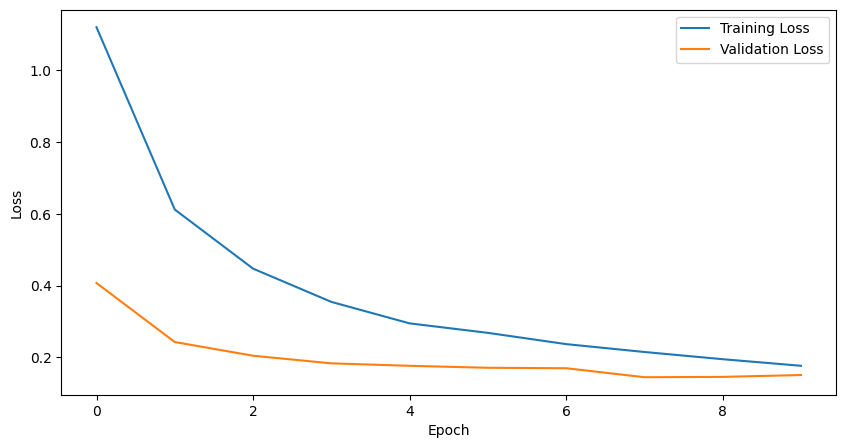

In [779]:
# Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

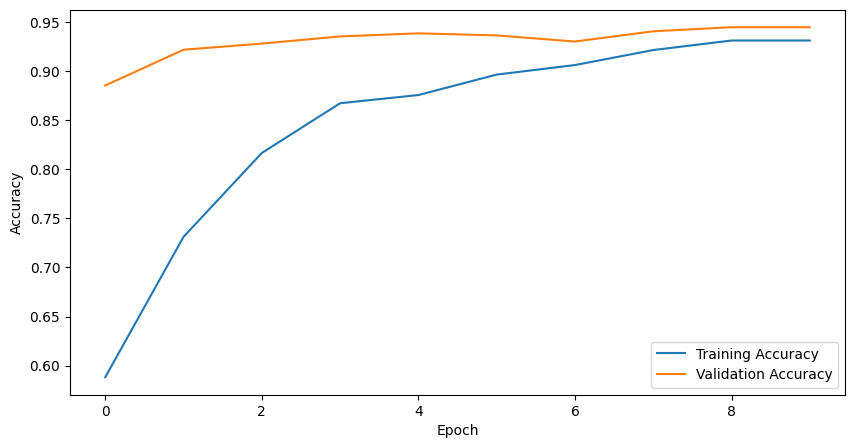

In [780]:
# Extract accuracy values
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot the accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Real + Fake image classifier

##Architecture

In [781]:
plant_embedding_real_fake = tf.keras.Sequential([
    # label input
    layers.Input(shape=(1024)),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Flatten(),
    layers.Dropout(0.4),
    # output
    layers.Dense(3, activation='softmax')
])

disease_embedding_real_fake = tf.keras.Sequential([
    # label input
    layers.Input(shape=(1024)),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Flatten(),
    layers.Dropout(0.4),
    # output
    layers.Dense(3, activation='softmax')
])

##Plant classifier

In [782]:
np.random.shuffle(real_fake_plant_dataset)
train, test = train_test_split(real_fake_plant_dataset, test_size = 0.4)

train_embeddings = np.array([item[0] for item in train])
train_labels = np.array([item[1] for item in train])

test_embeddings = np.array([item[0] for item in test])
test_labels = np.array([item[1] for item in test])

print("Train length: ", str(len(train_embeddings)))
print("Test length: ", str(len(test_embeddings)))

train_embeddings = train_embeddings.reshape(len(train_embeddings), 1024)
train_labels = tf.one_hot(train_labels, depth=3)

test_embeddings = test_embeddings.reshape(len(test_embeddings), 1024)
test_labels = tf.one_hot(test_labels, depth=3)

print(train_embeddings.shape)
print(test_embeddings.shape)

Train length:  1800
Test length:  1200
(1800, 1024)
(1200, 1024)


In [783]:
plant_embedding_real_fake.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])
plant_embedding_real_fake.summary()

Model: "sequential_88"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_424 (Dense)           (None, 512)               524800    
                                                                 
 dropout_194 (Dropout)       (None, 512)               0         
                                                                 
 dense_425 (Dense)           (None, 128)               65664     
                                                                 
 dense_426 (Dense)           (None, 32)                4128      
                                                                 
 flatten_116 (Flatten)       (None, 32)                0         
                                                                 
 dropout_195 (Dropout)       (None, 32)                0         
                                                                 
 dense_427 (Dense)           (None, 3)               

In [784]:
# train the model
history = model_fit = plant_embedding_real_fake.fit(train_embeddings, train_labels, epochs=10, validation_data=(test_embeddings, test_labels))

# evaluate model
_, real_fake_plant_train_acc = plant_embedding_real_fake.evaluate(train_embeddings, train_labels)
_, real_fake_plant_test_acc = plant_embedding_real_fake.evaluate(test_embeddings, test_labels )

print(f'\nTrain accuracy: {real_fake_plant_train_acc:.0%}')
print(f'Test accuracy: {real_fake_plant_test_acc:.0%}')

plant_embedding_real_fake.save('drive/MyDrive/Colab Notebooks/IIIP/Testing chamber/Models/plant_embedding_real_fake_classifier.hdf5')


Epoch 1/10
57/57 [==============================] - 2s 9ms/step - loss: 0.7575 - accuracy: 0.7117 - val_loss: 0.1036 - val_accuracy: 0.9717
Epoch 2/10
57/57 [==============================] - 0s 7ms/step - loss: 0.2408 - accuracy: 0.9083 - val_loss: 0.0615 - val_accuracy: 0.9800
Epoch 3/10
57/57 [==============================] - 0s 7ms/step - loss: 0.2065 - accuracy: 0.9294 - val_loss: 0.0501 - val_accuracy: 0.9833
Epoch 4/10
57/57 [==============================] - 0s 5ms/step - loss: 0.1463 - accuracy: 0.9444 - val_loss: 0.0461 - val_accuracy: 0.9825
Epoch 5/10
57/57 [==============================] - 0s 6ms/step - loss: 0.1313 - accuracy: 0.9539 - val_loss: 0.0451 - val_accuracy: 0.9842
Epoch 6/10
57/57 [==============================] - 0s 5ms/step - loss: 0.1076 - accuracy: 0.9589 - val_loss: 0.0469 - val_accuracy: 0.9842
Epoch 7/10
57/57 [==============================] - 0s 5ms/step - loss: 0.0850 - accuracy: 0.9722 - val_loss: 0.0513 - val_accuracy: 0.9858
Epoch 8/10
57/57 [==

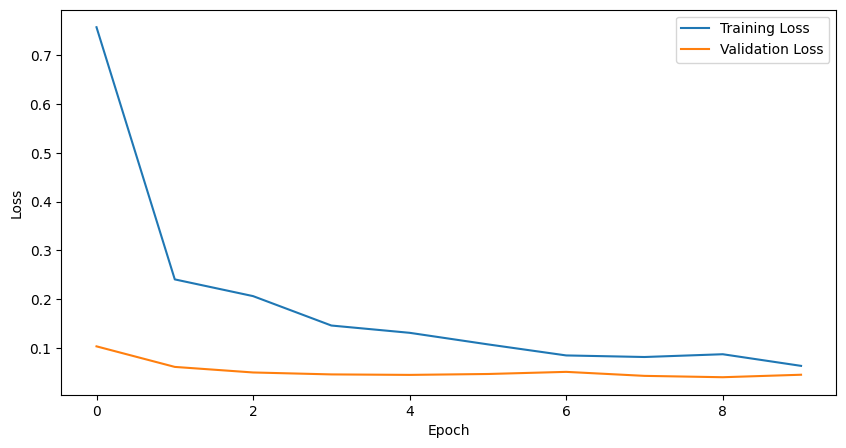

In [785]:
# Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

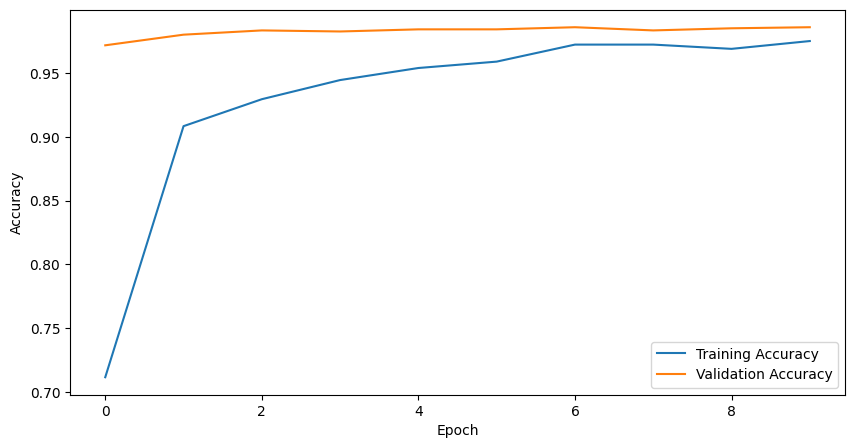

In [786]:
# Extract accuracy values
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot the accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

##Disease classifier

In [787]:
np.random.shuffle(real_fake_disease_dataset)

train, test = train_test_split(real_fake_disease_dataset, test_size = 0.4)

train_embeddings = np.array([item[0] for item in train])
train_labels = np.array([item[1] for item in train])

test_embeddings = np.array([item[0] for item in test])
test_labels = np.array([item[1] for item in test])

print("Train length: ", str(len(train_embeddings)))
print("Test length: ", str(len(test_embeddings)))

train_embeddings = train_embeddings.reshape(len(train_embeddings), 1024)
train_labels = tf.one_hot(train_labels, depth=3)

test_embeddings = test_embeddings.reshape(len(test_embeddings), 1024)
test_labels = tf.one_hot(test_labels, depth=3)

print(train_embeddings.shape)
print(test_embeddings.shape)

Train length:  1800
Test length:  1200
(1800, 1024)
(1200, 1024)


In [788]:
disease_embedding_real_fake.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])
disease_embedding_real_fake.summary()

Model: "sequential_89"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_428 (Dense)           (None, 512)               524800    
                                                                 
 dropout_196 (Dropout)       (None, 512)               0         
                                                                 
 dense_429 (Dense)           (None, 128)               65664     
                                                                 
 dense_430 (Dense)           (None, 32)                4128      
                                                                 
 flatten_117 (Flatten)       (None, 32)                0         
                                                                 
 dropout_197 (Dropout)       (None, 32)                0         
                                                                 
 dense_431 (Dense)           (None, 3)               

In [789]:
# train the model
history = model_fit = disease_embedding_real_fake.fit(train_embeddings, train_labels, epochs=10, validation_data=(test_embeddings, test_labels))

# evaluate model
_, real_fake_disease_train_acc = disease_embedding_real_fake.evaluate(train_embeddings, train_labels)
_, real_fake_disease_test_acc = disease_embedding_real_fake.evaluate(test_embeddings, test_labels )

print(f'\nTrain accuracy: {real_fake_disease_train_acc:.0%}')
print(f'Test accuracy: {real_fake_disease_test_acc:.0%}')

disease_embedding_real_fake.save('drive/MyDrive/Colab Notebooks/IIIP/Testing chamber/Models/disease_embedding_real_fake_classifier.hdf5')


Epoch 1/10
57/57 [==============================] - 2s 9ms/step - loss: 1.1940 - accuracy: 0.5567 - val_loss: 0.3862 - val_accuracy: 0.8958
Epoch 2/10
57/57 [==============================] - 0s 7ms/step - loss: 0.5225 - accuracy: 0.7622 - val_loss: 0.2361 - val_accuracy: 0.9283
Epoch 3/10
57/57 [==============================] - 0s 7ms/step - loss: 0.3665 - accuracy: 0.8578 - val_loss: 0.1737 - val_accuracy: 0.9358
Epoch 4/10
57/57 [==============================] - 0s 5ms/step - loss: 0.2992 - accuracy: 0.8811 - val_loss: 0.1491 - val_accuracy: 0.9442
Epoch 5/10
57/57 [==============================] - 0s 6ms/step - loss: 0.2416 - accuracy: 0.9044 - val_loss: 0.1337 - val_accuracy: 0.9517
Epoch 6/10
57/57 [==============================] - 0s 6ms/step - loss: 0.2145 - accuracy: 0.9217 - val_loss: 0.1197 - val_accuracy: 0.9517
Epoch 7/10
57/57 [==============================] - 0s 7ms/step - loss: 0.2050 - accuracy: 0.9239 - val_loss: 0.1261 - val_accuracy: 0.9542
Epoch 8/10
57/57 [==

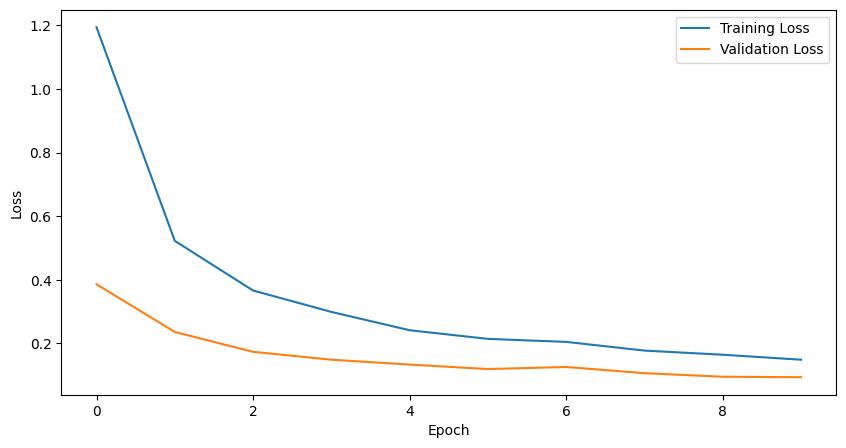

In [790]:
# Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

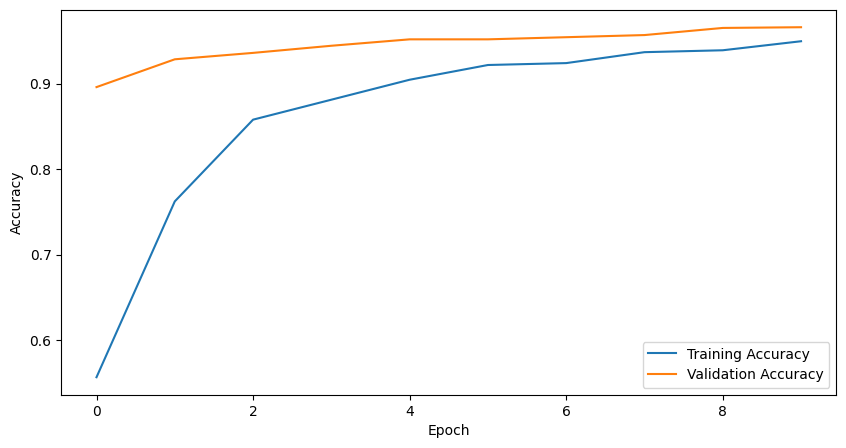

In [791]:
# Extract accuracy values
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot the accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Testing on unseen

In [792]:
unseen_embeddings = np.array(unseen_dataset)
unseen_embeddings = unseen_embeddings.reshape(len(unseen_embeddings), (1024))

In [793]:
plant_unseen_label = tf.one_hot(np.full(len(unseen_embeddings), 2), depth=3)
disease_unseen_label = tf.one_hot(np.ones(len(unseen_embeddings)), depth=3)

##Models trained on real dataset

In [794]:
loss, real_plant_acc = plant_embedding_real.evaluate(unseen_embeddings,plant_unseen_label)
loss, real_disease_acc = disease_embedding_real.evaluate(unseen_embeddings,disease_unseen_label)
print("True Label: Potato, accuracy: " + str(real_plant_acc*100))
print("True Label: Healthy, accuracy: " + str(real_disease_acc*100))

10/10 [==============================] - 0s 3ms/step - loss: 1.1006 - accuracy: 0.6513
True Label: Potato, accuracy: 18.421052396297455
True Label: Healthy, accuracy: 65.13158082962036


##Models trained on real+fake dataset

In [795]:
loss, real_fake_plant_acc = plant_embedding_real_fake.evaluate(unseen_embeddings,plant_unseen_label)
loss, real_fake_disease_acc = disease_embedding_real_fake.evaluate(unseen_embeddings,disease_unseen_label)
print("True Label: Potato, accuracy: " + str(real_fake_plant_acc*100))
print("True Label: Healthy, accuracy: " + str(real_fake_disease_acc*100))

10/10 [==============================] - 0s 3ms/step - loss: 0.7897 - accuracy: 0.7237
True Label: Potato, accuracy: 42.763158679008484
True Label: Healthy, accuracy: 72.36841917037964


In [796]:
print("Performance increase of plant classification: " + str(((real_fake_plant_acc - real_plant_acc)/real_plant_acc)*100))
print("Performance increase of disease classification: " + str(((real_fake_disease_acc - real_disease_acc)/real_disease_acc)*100))

Performance increase of plant classification: 132.14286436535883
Performance increase of disease classification: 11.111105010164483


In [797]:
print("=====================\nPlant model real embeddings\n=====================")
print("Training: " + str(real_plant_train_acc*100))
print("Test: " + str(real_plant_test_acc*100))
print("=====================\nDisease model real embeddings\n=====================")
print("Training: " + str(real_disease_train_acc*100))
print("Test: " + str(real_disease_test_acc*100))

Plant model real embeddings
Training: 99.09722208976746
Test: 98.1249988079071
Disease model real embeddings
Training: 97.63888716697693
Test: 94.47916746139526


In [798]:
print("=====================\nPlant model real + fake embeddings\n=====================")
print("Training: " + str(real_fake_plant_train_acc*100))
print("Test: " + str(real_fake_plant_test_acc*100))
print("=====================\nDisease model real + fake embeddings\n=====================")
print("Training: " + str(real_fake_disease_train_acc*100))
print("Test: " + str(real_fake_disease_test_acc*100))

Plant model real + fake embeddings
Training: 99.27777647972107
Test: 98.58333468437195
Disease model real + fake embeddings
Training: 98.11111092567444
Test: 96.5833306312561
